In [2]:
import tweepy
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer #Valence Aware Dictionary and sEntiment Reasoner lexicon
import numpy as np
sentiment = SentimentIntensityAnalyzer()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import config as config

In [3]:
#https://medium.com/black-tech-diva/hide-your-api-keys-7635e181a06c

In [4]:
consumer_key = config.consumer_key
consumer_secret = config.consumer_secret
access_key = config.access_key
access_secret = config.access_secret

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [115]:
swords = set(stopwords.words('english')) #set nltk stopword list equal to a variable
swords.update(['http', 'co', 'http co', 'ha', 'wa','amp']) #place to add custom stop words
 #add words to stopwords list
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+') #create tokenizer to remove punctuation
cvec = CountVectorizer(stop_words=swords, #remove stop words
                       ngram_range=(1,3),#single, paired, and triplet word patterns
                       max_df=.5, #ngram has to appear in given percentage or less of posts
                       min_df=3, #ngram has to appear at least this many times
                       max_features=1_000) #maximum 1k features

def tokemmetizer(dataframe): #create function to tokenize and lemmatize
    X = dataframe['text'] #analyze text
#    X_tokens = [tokenizer.tokenize(word) for word in X] #tokenize all words
#    X_lem = []
#    for item in X_tokens:
#        X_post = []
#        for word in item:
#            X_post.append(lemmatizer.lemmatize(word)) #remove stop words
#        X_lem.append(' '.join(X_post)) #rejoin lemmatized word list into strings
    #print(type(X_lem))
    X_c = cvec.fit_transform(X) #pass posts through count vectorizer
    X_c_df = pd.DataFrame(X_c.todense(), columns=cvec.get_feature_names()) #make df showing word frequency
    return X_c_df #return dataframe of values 

In [6]:
def osent(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'ERROR'

In [182]:
from IPython.display import Markdown as md

In [239]:
def desent(keyword, quantity=1000, counter=10):
    search_word = keyword
    all_tweets = []
    new_search = search_word + '-filter:retweets'
    for tweet in tweepy.Cursor(api.search, q=new_search, count=100,
                              lang='en', since_id=0).items():
        new = [tweet.created_at, tweet.id, tweet.text,
           tweet.user.screen_name, tweet.user.name, tweet.user.location,
              tweet.favorite_count]
        all_tweets.append(new)
        if len(all_tweets) == quantity: #stop at limit, default 1000
            break
    #create dataframe from list
    df = pd.DataFrame(all_tweets, columns=['created_at', 'id', 'text', 'screen_name', 'name', 'location', 'likes'])
    
    #create new columns of sentiment
    df['neg_sent'] = [list(sentiment.polarity_scores(text).values())[0] for text in df['text']] 
    df['neu_sent'] = [list(sentiment.polarity_scores(text).values())[1] for text in df['text']] 
    df['pos_sent'] = [list(sentiment.polarity_scores(text).values())[2] for text in df['text']] 
    df['comp_sent'] = [list(sentiment.polarity_scores(text).values())[3] for text in df['text']]
    df['overall_sent'] = [osent(score) for score in df['comp_sent']] #rate rows as positive, negative, or neutral
    
    if len(df) != quantity:
        print(f'Warning! Unable to find {quantity} tweets containing {keyword} in last 7 days')
        print(f'Only {len(df)} tweets found')
    
    saved_name = keyword + '_' + str(pd.Timestamp.now()).replace('-','_').replace(' ','_').replace(':','_').replace('.','_') #create name for file by concatenating keyword and datetime
    
    df.to_csv(f'./saved_searches/{saved_name}.csv', index=False) #save df as keyword_timestamp to avoid overwriting

    print(f'Dataframe saved as {saved_name}.csv') #print message confirming saved
    
    plt.figure(figsize=(12,8))
    plt.pie(df['overall_sent'].value_counts(normalize=True), 
            labels=list(dict(df['overall_sent'].value_counts()).keys()),
           colors=['blue', 'gray', 'orange'])
    plt.legend(fontsize='large')
    plt.title(f'Overall proportion of positive, neutral, and negative sentiment in {quantity} tweets containing "{keyword}"', size=25, color='white')
    plt.show()
    
    print(f"Starting date/time: {df['created_at'].min()}")
    print(f"Ending date/time: {df['created_at'].max()}")
    
    #display like distribution
    plt.figure(figsize=(12,8))
    df['likes'].hist(color='aqua')
    plt.title(f'Distribution of likes for {quantity} tweets containing "{keyword}"', size=25)
    plt.show()
    
    #display sentiment distribution
    plt.figure(figsize=(12,8))
    df['comp_sent'].hist(color='gold')
    plt.title(f'Distribution of sentiment across {quantity} tweets containing"{keyword}"', size=25)
    plt.show()
    
    #display 5 most liked tweets (full dataframe)
    display(df[['likes', 'text', 'name', 'comp_sent']].sort_values(by='likes', ascending=False).head(5))
    
    #print(df.shape)
    #sort tweets by composite score into postitive (greater than 0), negative (less than 0), or neutral (exactly 0)
    neutral = df[df['comp_sent']==0].copy() #neutral
    #print(df.shape)
    positive = df[df['comp_sent']>0].copy() #positive
    #print(df.shape)
    negative = df[df['comp_sent']<0].copy() #negative
    #print(df.shape)
    dflist = [neutral, positive, negative] #list of dataframes
    titles = ['neutral', 'positive', 'negative'] #list of df names (for plots)
    
    #print(df.shape)
    
    swords = set(stopwords.words('english')) #set nltk stopword list equal to a variable
    swords.update(['http', 'co', 'http co', 'ha', 'wa','amp', 'fo',
                   'https', 'ass', 'shit', 'fuck']) #place to add custom stop words
    
    cvec = CountVectorizer(stop_words=swords, #remove stop words
                       ngram_range=(1,2),#single or paired words
                       max_df=.3, #ngram has to appear in given percentage or less of posts
                       min_df=3, #ngram has to appear at least this many times
                       max_features=5_000) #maximum 5k features
    
    custom_stop_words = [] #place to store custom stop words which we will add in process
    top_30 = [] #collection of top 10 for each (pos,neg,neu), will be tested for duplicates
    custom_added = [] #keep track of words that are added to the stop list
    duplicates = True #by default we assume there are duplicates in common words between classifications
    
    #counter = 10 #set a counter to break the loop after 10 tries of removing duplicates
    while duplicates == True and counter > 0: #as long as there are duplicates among top 10 and counter > 0
    
        neu_vec = cvec.fit_transform(neutral['text']) #vectorize words for given classification
        neu_vec = pd.DataFrame(neu_vec.todense(), columns=cvec.get_feature_names()) #store in df

        pos_vec = cvec.fit_transform(positive['text'])
        pos_vec = pd.DataFrame(pos_vec.todense(), columns=cvec.get_feature_names())

        neg_vec = cvec.fit_transform(negative['text'])
        neg_vec = pd.DataFrame(neg_vec.todense(), columns=cvec.get_feature_names())
        
        #test if duplicates remain between top 10 of each class
        for tdf in [neu_vec, pos_vec, neg_vec]:
            for word in list(dict(tdf.sum().sort_values(ascending=False).head(10)).keys()):
                top_30.append(word) #create list of 30 words, top 10 from each category
        if len(top_30) == len(set(top_30)): #if there are no duplicates in the list
            duplicates = False #break out of the loop and continue
        else:
            for word in set(top_30):
                top_30.remove(word) #take out 1 copy of each word
            top_30 = list(set(top_30)) #whatever is left after removing 1 of each word from the list is a dup!
            swords.update(top_30) #add duplicate words to stop list for re-vectorization
            for word in top_30:
                custom_added.append(word) #keep track of what is being added to stop words
            top_30=[] #clear list for next run through
            counter-=1 #counter goes down by 1
    if counter == 0: #print a warning if counter break triggered
        print(f'Warning! Unable to remove duplicates after {counter} cycles!') 
    else:
        print(f'Duplicates removed after {10-counter} cycle(s)')
        
    print(f'Custom stop words: {custom_added}') #show duplicate words that were removed
    
    vec_df_list = [neu_vec, pos_vec, neg_vec] #list of category dfs, vectorized
    
    for n in range(len(vec_df_list)): #print visualizations for commone words in each category
        plt.figure(figsize=(12,8))
        vec_df_list[n].sum().sort_values(ascending=False).head(10).plot.barh(
            fontsize = '20',
            color='chartreuse'); #make bar chart of most frequent 10 words  
        plt.title(f'Most frequent words associated with {titles[n]} sentiment', size=25)
        plt.show(); #display each plot
    
    return 'Success'
        
    #display like distribution
#    plt.figure(figsize=(12,8))
#    df['likes'].hist(color='aqua')
#    plt.title(f'Distribution of likes for {quantity} tweets containing "{keyword}"', size=25)
#    plt.show()
    
    #display sentiment distribution
#    plt.figure(figsize=(12,8))
#    df['comp_sent'].hist(color='gold')
#    plt.title(f'Distribution of sentiment across {quantity} tweets containing"{keyword}"', size=25)
#    plt.show()
    
#    return df #return 5 most popular (liked) tweets

Dataframe saved as #epl_2021_05_21_14_02_20_036971.csv


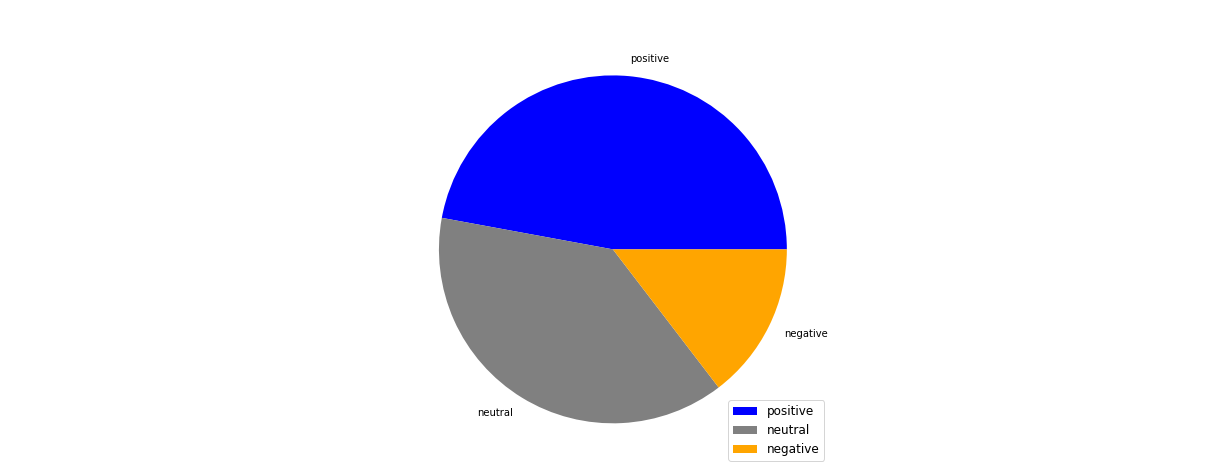

Starting date/time: 2021-05-19 19:40:14
Ending date/time: 2021-05-21 20:01:26


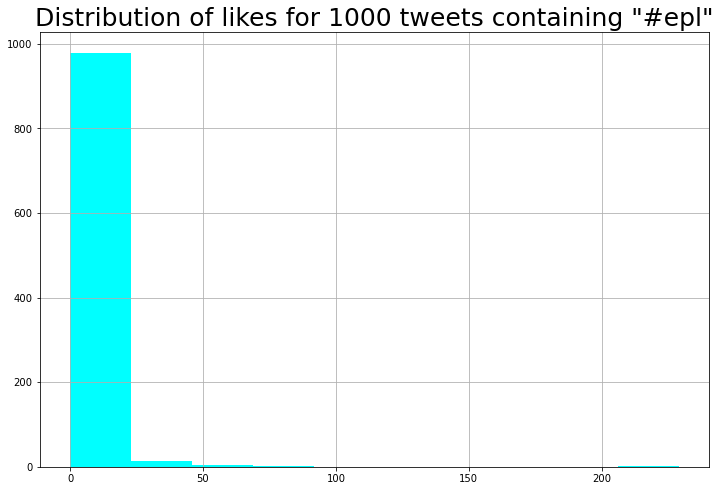

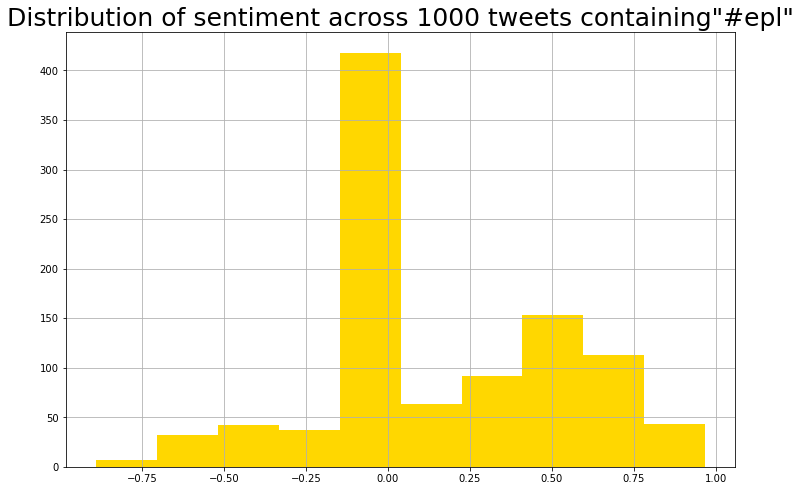

,likes,text,name,comp_sent
824,229,FT: Burnley 0-3 Liverpool (Firmino 43’ Phillips 52’ Chamberlain 88’) #EPL #MillardAyoSPORTS https://t.co/RvtfpZDYiv,millardayo,0.0000
843,90,Full Time | #EPL \nBurnley 0-3 Liverpool\n\n⚽️ Firmino 43'\n⚽️ Nath Phillips 52'\n⚽️ Oxlade 88'\n\nLiverpool naik ke posis… https://t.co/izQAPGKqIM,Extra Time Indonesia,0.0000
516,75,#EPL Gol musim ini: \n\nTimo Werner: 6 \n\nJoe Willock: 7 https://t.co/ddJmfuYabK,Siaran Bola Live,0.0000
647,70,Just curious as to why we don’t hear @jimbeglin and Peter Drury together anymore. Anybody? Any idea? \nI miss that p… https://t.co/1nkmi1O3dK,Masum.,0.2640
421,51,"Interesting turn of events here on Man Utd’s Harry #Maguire..\n\nObviously video would be better judge, but gone from… https://t.co/SfKEt1q3SK",InjuryMechanisms,0.4215


(1000, 12)
(1000, 12)
(1000, 12)
(1000, 12)
(1000, 12)
Duplicates removed after 5 cycle(s)
Custom stop words: ['top', 'premierleague', 'season', 'premier league', 'liverpool', 'premier', 'league', 'final', 'lfc', 'match', 'football', 'kane', 'arsenal', 'last', 'city', 'vs', 'chelsea', 'burnley', 'harry', 'live']


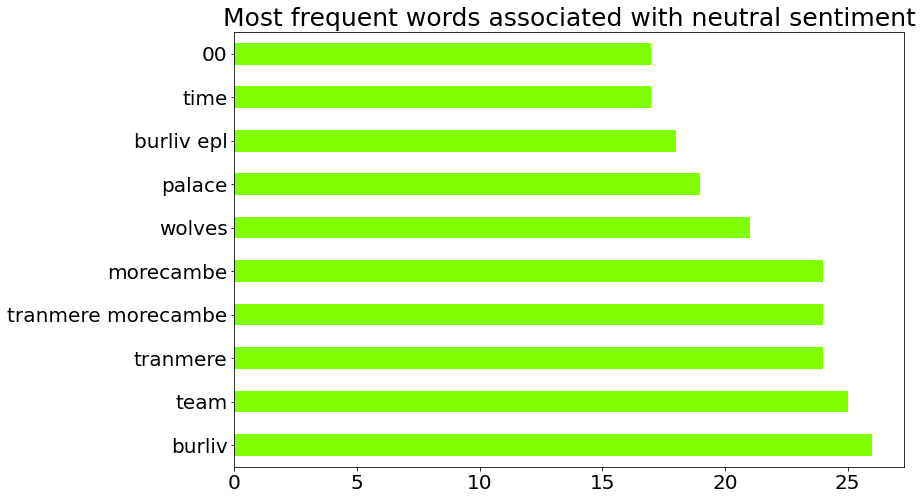

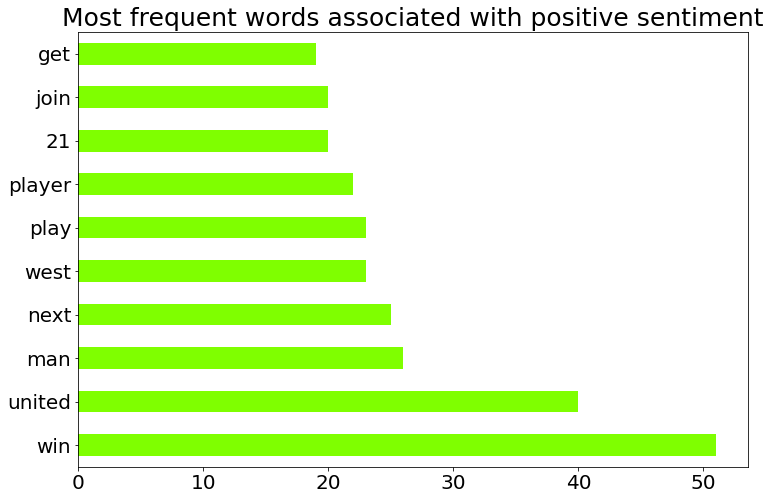

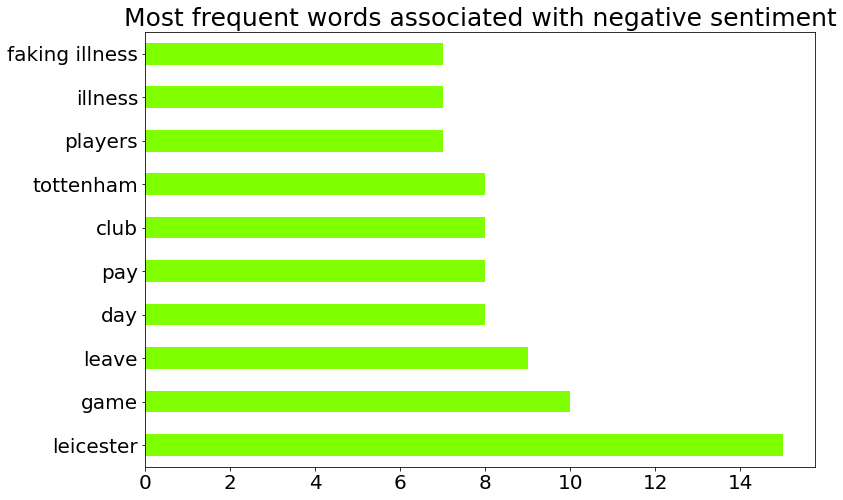

,created_at,id,text,screen_name,name,location,likes,neg_sent,neu_sent,pos_sent,comp_sent,overall_sent
0,2021-05-21 20:01:26,1395832125870546946,"Wolverhampton Wanderers manager Nuno Espirito Santo is to leave at the end of the season, the club said on Friday.… https://t.co/6QlOUJDL7z",ESPN_Caribbean,ESPN Caribbean,,0,0.057,0.943,0.000,-0.0516,negative
1,2021-05-21 19:58:57,1395831500344528900,Am going to miss Peter Dury 😢😢😢🤦‍♂️\n\n#EPL https://t.co/5ijWew3kd2,londaWorldwide,🌍 Phiwah🇮🇹.🇿🇦,Where i should be 😉,0,0.167,0.833,0.000,-0.1531,negative
2,2021-05-21 19:54:09,1395830293190348806,Guys I’m panicking. How do we usually cope when there’s no Premiere League game to look forward to again? This seas… https://t.co/CJ2xCpotOP,VicTorYLoga,V I C T O R Y,"Melbourne, Victoria, Australia",0,0.203,0.797,0.000,-0.6249,negative
3,2021-05-21 19:48:19,1395828824382771207,"Breaking: sex session reports untrue, protests West Bromwich Albion legend #EPL",EPLplayernews,#EPL player news,,0,0.160,0.840,0.000,-0.2263,negative
4,2021-05-21 19:47:56,1395828728157118466,I await the apologies..... ;) https://t.co/v1jJl3QczL #molineuxmix #wolverhamptonwanderers #wolves #wwfc… https://t.co/o6qUViQdKB,molineuxmix,Molineux Mix,Wolverhampton,0,0.000,0.708,0.292,0.3182,positive
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2021-05-19 19:45:22,1395103306956120067,How do turn the fan noise off on sky? #WBAWHU #EPL,StiofanEmary,Mr Emary (PE),Bedford/Hastings,1,0.000,0.813,0.187,0.3182,positive
996,2021-05-19 19:44:49,1395103166278946816,DINK THAT IN THIAGO!!!!!! #LFC #BURLIV #EPL,zubinofficial,Zubin Daver,Mumbai,1,0.000,1.000,0.000,0.0000,neutral
997,2021-05-19 19:44:29,1395103082384695300,Matheus Pereira take a bow #WBAWHU #WBA #WHUFC #PremierLeague #EPL,TheFootiePost,The Footie Post,"West Midlands, England",0,0.000,1.000,0.000,0.0000,neutral
998,2021-05-19 19:41:17,1395102276440711169,"Since losing to Brighton we are W4 D2 L2 F15 A14 Pts 14 This includes games v Man City (1), Leicester (4), Liverpoo… https://t.co/0FoGT2VcJw",drdanloaf,Dr Dan,,0,0.106,0.894,0.000,-0.3818,negative


In [238]:
desent('#epl')

In [ ]:
#filter out duplicates with stop words, count / track and print out w/count
#add time.sleep function on button in deployment to prevent throttling
#build in query
#twitter, facebook, reddit

I'm going to try a different angle on this project - finding the most popular positive and negative tweets. I'll start with the initial framework from above and then adjust as needed.

In [68]:
def desent2(keyword, quantity=1000):
    search_word = keyword
    all_tweets = []
    new_search = search_word + '-filter:retweets'
    for tweet in tweepy.Cursor(api.search, q=new_search, count=100,
                              lang='en', since_id=0).items():
        new = [tweet.created_at, tweet.id, tweet.text,
           tweet.user.screen_name, tweet.user.name, tweet.user.location, #all the same paramaters as above
              tweet.favorite_count #NEW count number of "likes"
              ] 
        all_tweets.append(new)
        if len(all_tweets) == quantity: #stop at limit, default 1000
            break
    #create dataframe from list
    df = pd.DataFrame(all_tweets, columns=['created_at', 'id', 'text', 'screen_name', 'name', 'location',
                                          'likes'])
    
    #create new columns of sentiment
    df['neg_sent'] = [list(sentiment.polarity_scores(text).values())[0] for text in df['text']] 
    df['neu_sent'] = [list(sentiment.polarity_scores(text).values())[1] for text in df['text']] 
    df['pos_sent'] = [list(sentiment.polarity_scores(text).values())[2] for text in df['text']] 
    df['comp_sent'] = [list(sentiment.polarity_scores(text).values())[3] for text in df['text']]
    df['overall_sent'] = [osent(score) for score in df['comp_sent']] #rate rows as positive, negative, or neutral
    #print(df['overall_sent'].value_counts(normalize=True)) #print breakdown of sentiment
    plt.pie(df['overall_sent'].value_counts(normalize=True), 
            labels=list(dict(df['overall_sent'].value_counts()).keys()))
    plt.legend()
    plt.show()
    return df

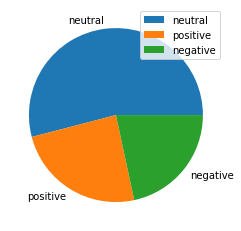

In [89]:
test_df = desent2('#elmo')

In [90]:
test_df.shape

(37, 12)

In [123]:
#test_df

In [ ]:
#know when search term is popular

In [119]:
#test_df.sort_values(by='likes', ascending=False)

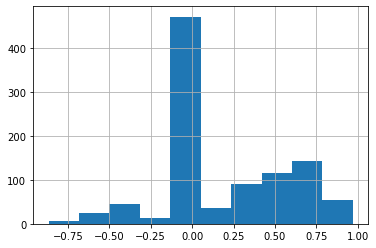

In [71]:
test_df['comp_sent'].hist(); #view sentiment distribution

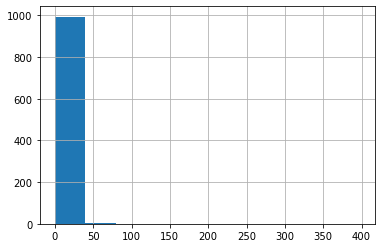

In [72]:
test_df['likes'].hist(); #view like distribution

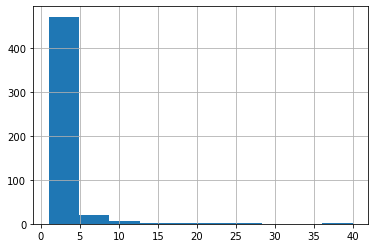

In [73]:
test_df['name'].value_counts().hist(); #unique posters

In [74]:
test_df['created_at'].min()

Timestamp('2021-05-17 05:00:35')

In [75]:
test_df['created_at'].max() #3 hr range

Timestamp('2021-05-19 19:12:00')

In [76]:
test_df['location'].value_counts()

Denver, CO                        303
                                  151
Vancouver, British Columbia       40 
Denver, Colorado                  31 
Colorado Springs, CO              29 
                                  .. 
Elizabeth, CO                     1  
Home of PATS, RED SOX & BRUINS    1  
Los Angeles, 🇸🇻, 🇺🇸               1  
7001 Yampa Street Denver, CO      1  
Nationwide, USA                   1  
Name: location, Length: 182, dtype: int64

In [77]:
#follower count for each handle?
#segment sent score (quadrants - percentage - quartiles), then scale likes
#engagement percentage - review standard social media metrics
    #number of people that engage divided by # of followers?
        #likes / followers = engagement score?
#counts of retweets, comments


In [78]:
#drop tweets with zero likes
test_df = test_df[test_df['likes']>0]

In [79]:
test_df['comp_sent'].describe() #quartiles

count    302.000000
mean     0.200892  
std      0.371583  
min     -0.867100  
25%      0.000000  
50%      0.000000  
75%      0.589275  
max      0.921700  
Name: comp_sent, dtype: float64

In [80]:
description = dict(test_df['comp_sent'].describe())

In [81]:
print(
    description['min'],
    description['25%'],
    description['50%'],
    description['75%'],
    description['max']
) #test printing ranges

-0.8671 0.0 0.0 0.589275 0.9217


In [82]:
print(
    'min-25% \n',
    test_df[test_df['comp_sent']<=description['25%']]['id'].count(),
    '--- \n',
    '25%-50% \n',
    test_df[(test_df['comp_sent']>description['25%']) & (test_df['comp_sent']<=description['50%'])]['id'].count(),
    '--- \n',
    '50%-75% \n',
    test_df[(test_df['comp_sent']>description['50%']) & (test_df['comp_sent']<=description['75%'])]['id'].count(),
    '--- \n',
    '75%-max \n',
    test_df[(test_df['comp_sent']>description['75%']) & (test_df['comp_sent']<=description['max'])]['id'].count()
)

min-25% 
 172 --- 
 25%-50% 
 0 --- 
 50%-75% 
 54 --- 
 75%-max 
 76


In [83]:
test_df.shape

(302, 12)

In [84]:
pd.options.display.max_colwidth=0 #show full text

In [85]:
test_df[['text', 'comp_sent', 'likes']].sort_values(by='likes', ascending=False)

,text,comp_sent,likes
830,This setup is simply amazing. Just look at that Thelio 😍 \n\n📷: @entropyhq \n\n#System76 #Thelio #Desktop #Setup… https://t.co/0u4TbMfQLh,0.5859,397
821,As of yesterday there are no capacity restrictions or general mask mandates in #Denver — we are in “Level Clear.”… https://t.co/aO96xER7NP,-0.2960,238
415,"Seriously, #Denver?! Or should I say Seattle’s twin?! 🌧🌨 #9wx https://t.co/yC5EJJTaZY",-0.3907,82
904,Denver Nuggets sets thread.\n1. Horns back screen to elbow hand-off\n#NBA #NBATwitter #basketball #Nuggets #Denver https://t.co/5vxjh0ktNj,0.0000,79
413,Just wanted to say THANKS to Dr Cutarelli at @cutarellivision ! He did my Lasik surgery and now my cataract surge… https://t.co/WXPZ3n66KR,0.6027,65
...,...,...,...
406,#Suspect arrested in #fatal #shooting at southeast #Denver apartment complex - May 18 @ 4:23 PM ET https://t.co/M06BuWcnCu,-0.4767,1
408,The continued efforts from @VillasArmy nation wide and @MileHighLokos for @miseleccionmxEN and @ColoradoRapids here… https://t.co/7xKa8W7JCg,0.0000,1
411,Leeeets Goo🤗!!! \n🎵🎶🤸‍♀️\n\n#Denver to #LasVegas \n#EDM #Vegasbound #Sincity @deadmau5 #Deadmau5 @insomniacevents https://t.co/EXxtOZHZZg,0.0000,1
412,Women and people of color in the #Denver region can apply for the Real Estate Diversity Initiative (REDI) training… https://t.co/y6GgWoCHmx,0.0000,1


In [120]:
#test_df

In [124]:
t1 = cvec.fit_transform(test_df['text'])
t1 = pd.DataFrame(t1.todense(), columns=cvec.get_feature_names())
#list(t1.sum().sort_values(ascending=False).head(10)

cd                    8
sesamestreet          7
sesame                6
street                6
sesame street         6
elmo sesame           5
elmo sesame street    5
hot                   5
street cd             4
check elmo            4
dtype: int64

In [130]:
list(dict(t1.sum().sort_values(ascending=False).head(10)).keys())

['cd',
 'sesamestreet',
 'sesame',
 'street',
 'sesame street',
 'elmo sesame',
 'elmo sesame street',
 'hot',
 'street cd',
 'check elmo']

In [25]:
test_df[test_df['comp_sent']<=description['25%']].sort_values(by='comp_sent')

,created_at,id,text,screen_name,name,location,likes,neg_sent,neu_sent,pos_sent,comp_sent,overall_sent
419,2021-05-17 12:45:04,1394272755986612228,Log Lane Village police chief arrested on susp...,policeofficer,Raymond E. Foster,"San Dimas, CA",3,0.495,0.505,0.0,-0.8689,negative
332,2021-05-17 15:05:48,1394308174723706883,#Colorado Insurrectionist Violates NO GUN Orde...,jimodonnell2,Jim O'Donnell,Taos New Mexico,3,0.539,0.461,0.0,-0.8543,negative
333,2021-05-17 15:05:03,1394307987133456384,How the HELL is it so hard to get a Covid rapi...,AuthorDelaneyW,"Delaney Williams, Antifa treasurer","Denver, CO",1,0.254,0.746,0.0,-0.8172,negative
835,2021-05-16 12:00:01,1393899033358344193,#Colorado a #dog has been killed and another i...,ActionRspca,Community Action to Reform RSPCA,"England, Wales and beyond",2,0.356,0.644,0.0,-0.8020,negative
143,2021-05-17 20:15:03,1394385998755385344,After a #Colorado man was arrested for alleged...,newsbreakApp,News Break,"Mountain View, CA",2,0.283,0.717,0.0,-0.7717,negative
...,...,...,...,...,...,...,...,...,...,...,...,...
405,2021-05-17 13:03:48,1394277472691113986,I spent some time stalking hummingbirds this w...,bgordonphotogr1,b_gordon_photography,"Denver, CO",6,0.000,1.000,0.0,0.0000,neutral
406,2021-05-17 13:03:44,1394277456253698051,"""This is a book you’ll long remember after rea...",MaryLSchmidt,"Mary L Schmidt, Author aka #SJackson #MultiAwards",Colorado,3,0.000,1.000,0.0,0.0000,neutral
407,2021-05-17 13:03:27,1394277383734276099,"""This is a book you’ll long remember after rea...",MaryLSchmidt,"Mary L Schmidt, Author aka #SJackson #MultiAwards",Colorado,3,0.000,1.000,0.0,0.0000,neutral
367,2021-05-17 14:23:28,1394297519119556613,A SUMMARY OF VISCOUNT'S DRILLING IN KATE EAST ...,ViscountMining,Viscount Mining Inc.,"Vancouver, BC",4,0.000,1.000,0.0,0.0000,neutral


In [68]:
print(
    test_df['comp_sent'].min(),
    #list(test_df['comp_sent'].sort_values())[0], #should be same as min TRUE
    list(test_df['comp_sent'].sort_values())[249],
    list(test_df['comp_sent'].sort_values())[499],
    list(test_df['comp_sent'].sort_values())[749],
    #list(test_df['comp_sent'].sort_values())[999], #should be same as max TRUE
    test_df['comp_sent'].max()
)

-0.8685 0.0 0.0258 0.5859 0.9605


In [69]:
splits = {
    'min':test_df['comp_sent'].min(),
    '25%':list(test_df['comp_sent'].sort_values())[249],
    '50%':list(test_df['comp_sent'].sort_values())[499],
    '75%':list(test_df['comp_sent'].sort_values())[749],
    'max':test_df['comp_sent'].max()
}#create dictionary of EVEN 25% segments

In [70]:
splits #preview

{'min': -0.8685, '25%': 0.0, '50%': 0.0258, '75%': 0.5859, 'max': 0.9605}

In [ ]:
print(
    'min-25% \n',
    test_df[test_df['comp_sent']<=description['25%']]['comp_sent'].count(),
    '--- \n',
    '25%-50% \n',
    test_df[(test_df['comp_sent']>description['25%']) & (test_df['comp_sent']<=description['50%'])]['comp_sent'].count(),
    '--- \n',
    '50%-75% \n',
    test_df[(test_df['comp_sent']>description['50%']) & (test_df['comp_sent']<=description['75%'])]['comp_sent'].count(),
    '--- \n',
    '75%-max \n',
    test_df[(test_df['comp_sent']>description['75%']) & (test_df['comp_sent']<=description['max'])]['comp_sent'].count()
)